In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import eurostat
import numpy as np
from tqdm import tqdm
from pmdarima.arima import auto_arima
import warnings
import pickle
import xgboost as xgb
from sklearn.metrics  import mean_squared_error as mse_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from sklearn.model_selection import GridSearchCV
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape_score
from sklearn.metrics import r2_score
from joblib import Parallel
from joblib import delayed
from os import cpu_count

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

In [2]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]


# ARIMA/ SARIMA

In [3]:
def smooth(ts, w = 12):
    smoothts = ts.rolling(window=w).mean().dropna()
    return smoothts

def split(ts, p = 0.8):
    train = ts[:round(p*len(ts))]
    test = ts[round(p*len(ts)):]
    return train, test

In [4]:
ts = tsprod["Ethanol"]["DE"].Tons
ts = smooth(ts)
train, test = split(ts)
train.tail()

TIME_PERIOD
2016-02-01    78004.337167
2016-03-01    78230.437167
2016-04-01    78428.281917
2016-05-01    79256.266667
2016-06-01    78222.831083
Name: Tons, dtype: float64

### Experiment

In [5]:
ts = tsprod["Ethanol"]["DE"].Tons
#ts = smooth(ts)
train, test = split(ts)
train = smooth(train)
with catch_warnings():
    filterwarnings("ignore")
    sarima_model = SARIMAX(train, seasonal_order=(4, 1, 1, 12), enforce_invertibility=False, enforce_stationarity=False)
    sarima_fit = sarima_model.fit()
sarima_fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Tons   No. Observations:                  329
Model:             SARIMAX(1, 0, 0)x(4, 1, [1], 12)   Log Likelihood               -2309.479
Date:                              Sat, 09 Sep 2023   AIC                           4632.957
Time:                                      03:14:24   BIC                           4658.094
Sample:                                  12-01-1988   HQIC                          4643.054
                                       - 04-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.006    179.077      0.000       0.989       1.011
ar.S.L12      -0.1121      0.111     -1.011      0.312      -0.329       0.105
ar.S.L24       0.0105      0.118      0.089      0.929      -0.221       0.242
ar.S.L36       0.1366      0.126      1.080      0.280      -0.111       0.384
ar.S.L48      -0.1357      0.127     -1.065      0.287      -0.385       0.114
ma.S.L12      -0.9062      0.144     -6.293      0.000      -1.188      -0.624
sigma2      2.693e+06   1.09e-07   2.48e+13      0.000    2.69e+06    2.69e+06
===================================================================================
Ljung-Box (L1) (Q):                  46.38   Jarque-Bera (JB):                91.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.36   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  8e+28. Standard errors may be unstable.
"""

(2016-05-01    371.672647
 2016-06-01    351.041032
 2016-07-01    339.762015
 2016-08-01    336.616615
 2016-09-01    333.036344
                  ...    
 2033-11-01    376.037213
 2033-12-01    377.853296
 2034-01-01    373.415208
 2034-02-01    369.688417
 2034-03-01    372.876914
 Freq: MS, Name: predicted_mean, Length: 215, dtype: float64,
 242.07)

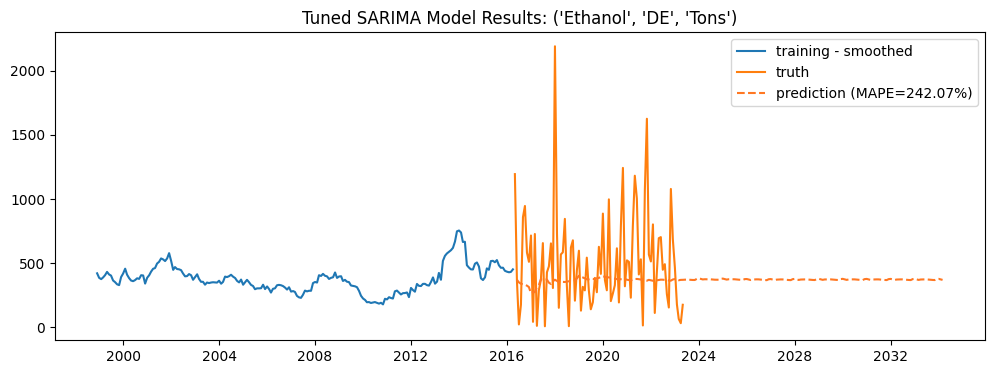

In [273]:
def plot_sarima_forecast(sarima_fit, train, test, horizon, title, freq = 'M'):

    sarima_pred = sarima_fit.forecast(len(test)+horizon)
    extended_index = pd.date_range(start=test.index[0], end=sarima_pred.index[-1], freq=freq)
    #predicted_means = sarima_pred.predicted_mean
    #predicted_intervals = sarima_pred.conf_int(alpha=0.05)
    #lower_bounds = predicted_intervals['lower Tons']
    #upper_bounds = predicted_intervals['upper Tons']

    # metrics
    rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values))), 2)
    mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values)/test.values*100)), 2)
    #sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max()).predicted_mean.values)/df.values*100))

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train.index, train.values, label = "training - smoothed")
    #ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
    ax.plot(test.index, test.values, label='truth')
    ax.plot(extended_index, sarima_pred[:-1], color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
    #ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
    ax.legend()
    ax.set_title(f"Tuned SARIMA Model Results: {title}")
    return sarima_pred, mape

horizon = 130
p = "Ethanol"
geo = "DE"
field = "Tons"
plot_sarima_forecast(sarima_fit, train, test, horizon, (p, geo, field))

In [7]:
train.index[0]

Timestamp('1988-12-01 00:00:00')

In [4]:

 
# one-step sarima forecast
def sarima_forecast(train, test, config):
    order, sorder, trend = config
    # define model
    model = ARIMA(train, order=order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit()
    # make one step forecast
    yhat = model_fit.forecast(len(test))
    return yhat

# split a univariate dataset into train/test sets
def train_test_split(ts, p):
    train = ts[:round(p*len(ts))]
    test = ts[round(p*len(ts)):]
    return train, test

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    # step over each time-step in the test set
        # fit model and make forecast for history
    predictions = sarima_forecast(train, test, cfg)
        # store forecast in list of predictions
        # add actual observation to history for the next loop
    # estimate prediction error
    error = (round(mape_score(test, predictions)*100, 2), round(r2_score(test, predictions)*100, 2))

    
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
#    if result is not None:
#        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
    scores = []
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        for cfg in tqdm(cfg_list):
            scores.append(score_model(data, n_test, cfg))
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0], P=range(5), D=range(2), Q=range(5), m=12):
    models = list()
    models = list()
    # define config lists
    p_params = range(5)
    d_params = range(4)
    q_params = range(5)
    #t_params = ['n','c','t','ct']
    P_params = P
    D_params = D
    Q_params = Q
    #m_params = [12]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                #for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            #for m in m_params:
                            cfg = [(p, d, q), (P, D, Q, m), None]
                            models.append(cfg)
    return models

In [158]:
psplit= 0.8
cfg_list = sarima_configs(P = [0], D = [0], Q = [0], m = 0)

crconfigs = {} 
for p in tscrops.keys():
    for geo in tscrops[p].keys():
        ts = tscrops[p][geo].Mtons_Waste
        scores = grid_search(ts, cfg_list, psplit)
        crconfigs[f"{p}-{geo}-Tons"] = scores[0]

crconfigs

100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


{'Wheat-BE-Tons': ('[(2, 0, 2), (0, 0, 0, 0), None]', (4.13, -25.34)),
 'Wheat-ES-Tons': ('[(4, 3, 1), (0, 0, 0, 0), None]', (7.19, 58.81)),
 'Wheat-FR-Tons': ('[(4, 2, 4), (0, 0, 0, 0), None]', (4.55, 49.05)),
 'Maize-BE-Tons': ('[(1, 2, 4), (0, 0, 0, 0), None]', (5.25, -13.62)),
 'Maize-ES-Tons': ('[(3, 0, 2), (0, 0, 0, 0), None]', (3.5, 15.72)),
 'Maize-FR-Tons': ('[(0, 3, 3), (0, 0, 0, 0), None]', (4.55, 18.45)),
 'Beet-BE-Tons': ('[(1, 0, 1), (0, 0, 0, 0), None]', (4.07, -18.78)),
 'Beet-ES-Tons': ('[(1, 2, 1), (0, 0, 0, 0), None]', (3.6, 80.96)),
 'Beet-FR-Tons': ('[(1, 0, 0), (0, 0, 0, 0), None]', (10.5, 29.11))}

In [379]:
cfgs = {
    'Wheat-BE-Tons': ([(2, 0, 2), (0, 0, 0, 12), None], (4.13, -25.34)),
    'Wheat-ES-Tons': ([(4, 3, 1), (0, 0, 0, 12), None], (7.19, 58.81)),
    'Wheat-FR-Tons': ([(4, 2, 4), (0, 0, 0, 12), None], (4.55, 49.05)),
    'Maize-BE-Tons': ([(1, 2, 4), (0, 0, 0, 12), None], (5.25, -13.62)),
    'Maize-ES-Tons': ([(3, 0, 2), (0, 0, 0, 12), None], (3.5, 15.72)),
    'Maize-FR-Tons': ([(2, 2, 1), (0, 0, 0, 12), None], (4.55, 18.45)),
    'Beet-BE-Tons': ([(1, 0, 1), (0, 0, 0, 12), None], (4.07, -18.78)),
    'Beet-ES-Tons': ([(2, 0, 3), (0, 0, 0, 12), None], (3.6, 80.96)),
    'Beet-FR-Tons': ([(1, 0, 0), (0, 0, 0, 12), None], (10.5, 29.11))
}

In [380]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]

import copy

In [381]:
forecast_crops = copy.copy(tscrops)

In [382]:
@interact
def resultsplot(Dataset = list(cfgs.keys())):
    with catch_warnings():
        filterwarnings("ignore")
        p = Dataset.split("-")[0]
        geo = Dataset.split("-")[1]
        ts = tscrops[p][geo].Mtons_Waste
        #ts = smooth(ts)
        train, test = split(ts)
        t = None
        if p == "Beet" and geo == "ES":
            train, test = split(ts, 0.7)
            t = 'c'
        #train = smooth(train)
        sarima_model = ARIMA(train, order=cfgs[Dataset][0][0], trend=t,  enforce_invertibility=False, enforce_stationarity=False)
        sarima_fit = sarima_model.fit()

        sarima_pred = sarima_fit.forecast(len(test)+13)
        extended_index = list(range(test.index.min(), test.index.max() + 14))

        # metrics
        mape = round(mape_score(test, sarima_fit.forecast(len(test)))*100, 2)
        rmse = round(math.sqrt(mse_score(test, sarima_fit.forecast(len(test)))), 2)

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(train.index, train.values, label = "Training (80/20 split)")
        #ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
        ax.plot(test.index, test.values, label='Truth (80/20 split)')
        ax.plot(extended_index, sarima_pred, color='#ff7823', linestyle='--', label=f"prediction (MAPE={mape}%, RMSE = {rmse})")
        #ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
        ax.legend()
        ax.set_ylabel("Million tons")
        ax.set_title(f"Tuned ARIMA Model Results: {p, geo}")
        forecast_crops[p][geo] = {}
        forecast_crops[p][geo]["Forecast"] = sarima_pred
        forecast_crops[p][geo]["MAPE"] = mape


interactive(children=(Dropdown(description='Dataset', options=('Wheat-BE-Tons', 'Wheat-ES-Tons', 'Wheat-FR-Ton…

In [383]:
forecast_crops["Wheat"]["BE"]["Forecast"]

18    2.733786
19    2.739344
20    2.501009
21    2.368106
22    2.517670
23    2.720965
24    2.691375
25    2.487174
26    2.405131
27    2.550333
28    2.704172
29    2.652114
30    2.481687
31    2.438562
32    2.573337
33    2.685531
34    2.620810
35    2.482177
Name: predicted_mean, dtype: float64

In [384]:
with open(f'arima_forecast_crops.pickle', 'wb') as f:
    pickle.dump(forecast_crops, f)

In [6]:
fconfigs = {
    'Maize-BE-Tons': ([(2, 0, 1), (2, 1, 0, 12), None], (29.6, -24.61)),
    'Maize-ES-Tons': ([(1, 0, 1), (3, 1, 0, 12), None], (45.03, -21.13)),
    'Maize-FR-Tons': ([(2, 1, 1), (2, 0, 2, 12), None], (36.13, -24.0)),
    'Wheat-BE-Tons': ([(1, 1, 1), (0, 1, 2, 12), None], (12.65, 6.59)),
    'Wheat-ES-Tons': ([(2, 0, 1), (2, 0, 2, 12), None], (16.73, -0.12)),
    'Wheat-FR-Tons': ([(1, 0, 0), (1, 1, 2, 12), None], (16.65, 9.75)),
    'Beet-BE-Tons': ([(1, 0, 0), (1, 1, 1, 12), None], (24.43, -28.36)),
    'Beet-ES-Tons': ([(0, 0, 1), (3, 1, 3, 12), None], (99.81, -181.12)),
    'Beet-FR-Tons': ([(2, 1, 0), (0, 0, 1, 12), None], (21.91, -12.71))
 }

In [9]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]

import copy
forecast_feed = copy.copy(tsfeed)

In [13]:
@interact
def resultsplot(Dataset = list(fconfigs.keys())):
    with catch_warnings():
        filterwarnings("ignore")
        p = Dataset.split("-")[0]
        geo = Dataset.split("-")[1]
        ts = tsfeed[p][geo].Price
        #print(fconfigs[Dataset][0][1])
        trainf, test = split(ts)
        train = trainf

        if p == "Beet" and geo == "ES":
            train = train[train.index >= "1998"]
        elif p == "Beet" and geo == "BE":
            pass
        elif p == "Maize" and geo == "ES":
            pass
        else:
            train = smooth(train)
        t = None
        sarima_model = SARIMAX(train, order=fconfigs[Dataset][0][0], seasonal_order=fconfigs[Dataset][0][1], trend=t,  enforce_invertibility=False, enforce_stationarity=False)
        sarima_fit = sarima_model.fit()
        
        horizon = 130
        sarima_pred = sarima_fit.forecast(len(test)+horizon)
        extended_index = pd.date_range(start=test.index[0], end=sarima_pred.index[-1], freq="M")
        #predicted_means = sarima_pred.predicted_mean
        #predicted_intervals = sarima_pred.conf_int(alpha=0.05)
        #lower_bounds = predicted_intervals['lower Tons']
        #upper_bounds = predicted_intervals['upper Tons']

        # metrics
        rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values))), 2)
        mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values)/test.values*100)), 2)
        #sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max()).predicted_mean.values)/df.values*100))

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(train.index, train.values, label = "Training - Smoothed")
        #ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
        ax.plot(test.index, test.values, label='Test (80/20 split)')
        ax.plot(extended_index, sarima_pred[:-1], color='#ff7823', linestyle='--', label=f"prediction (MAPE={mape}%)")
        #ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
        ax.legend()
        ax.set_title(f"Tuned SARIMA Model Results: {p, geo} (Price €/tons)")
        #print(sarima_pred.tail())
        #forecast_feed[p][geo] ={}
        #forecast_feed[p][geo]["Forecast"] = sarima_pred
        #forecast_feed[p][geo]["MAPE"] = mape

interactive(children=(Dropdown(description='Dataset', options=('Maize-BE-Tons', 'Maize-ES-Tons', 'Maize-FR-Ton…

In [371]:
forecast_feed["Maize"]["BE"]["Forecast"]

2016-05-01    165.405227
2016-06-01    166.967933
2016-07-01    168.807740
2016-08-01    169.225076
2016-09-01    170.556791
                 ...    
2033-11-01    175.114456
2033-12-01    176.694675
2034-01-01    178.378438
2034-02-01    179.285364
2034-03-01    177.821828
Freq: MS, Name: predicted_mean, Length: 215, dtype: float64

In [372]:
with open(f'arima_forecast_feed.pickle', 'wb') as f:
    pickle.dump(forecast_feed, f)

In [13]:
pconfigs ={
    'LA-BE-Price': ([(0, 0, 0), (3, 1, 1, 12), None], (14.4, -10.92)),
    'LA-DE-Price': ([(2, 0, 1), (1, 0, 1, 12), None], (11.19, 6.67)),
    'LA-NL-Price': ([(1, 0, 0), (2, 1, 1, 12), None], (15.65, 39.89)),
    'Ethanol-DE-Price': ([(2, 1, 0), (1, 1, 0, 12), None], (13.05, 37.53)),
    'Ethanol-FR-Price': ([(1, 0, 0), (2, 1, 1, 12), None], (16.58, 39.77)),
    'Ethanol-NL-Price': ([(1, 1, 1), (1, 1, 1, 12), None], (16.1, -10.37)),
    'SA-DE-Price': ([(1, 0, 0), (2, 1, 1, 12), None], (10.85, 52.84)),
    'SA-IT-Price': ([(2, 0, 1), (0, 0, 2, 12), None], (15.72, 23.89)),
    'SA-NL-Price': ([(1, 0, 1), (4, 0, 2, 12), None], (17.41, -11.33))
 }

In [14]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]

import copy
#forecast_prod_price = copy.copy(tsprod)

In [16]:
@interact
def resultsplot(Dataset = list(pconfigs.keys())):
    with catch_warnings():
        filterwarnings("ignore")
        p = Dataset.split("-")[0]
        geo = Dataset.split("-")[1]
        ts = tsprod[p][geo].Price
        #print(fconfigs[Dataset][0][1])
        trainf, test = split(ts)
        train = trainf

        if p == "Beet" and geo == "ES":
            train = train[train.index >= "1998"]
        elif p == "Beet" and geo == "BE":
            pass
        elif p == "Maize" and geo == "ES":
            pass
        else:
            train = smooth(train)
        t = None
        sarima_model = SARIMAX(train, order=pconfigs[Dataset][0][0], seasonal_order=pconfigs[Dataset][0][1], trend=t,  enforce_invertibility=False, enforce_stationarity=False)
        sarima_fit = sarima_model.fit()
        
        horizon = 130
        sarima_pred = sarima_fit.forecast(len(test)+horizon)
        extended_index = pd.date_range(start=test.index[0], end=sarima_pred.index[-1], freq="M")
        #predicted_means = sarima_pred.predicted_mean
        #predicted_intervals = sarima_pred.conf_int(alpha=0.05)
        #lower_bounds = predicted_intervals['lower Tons']
        #upper_bounds = predicted_intervals['upper Tons']

        # metrics
        rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values))), 2)
        mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values)/test.values*100)), 2)
        #sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max()).predicted_mean.values)/df.values*100))

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(train.index, train.values, label = "Training - Smoothed")
        #ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
        ax.plot(test.index, test.values, label='Test (80/20 split)')
        ax.plot(extended_index, sarima_pred[:-1], color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
        #ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
        ax.legend()
        ax.set_title(f"Tuned SARIMA Model Results: {p, geo} (Price €/tons)")
        print(sarima_pred[-10:])
        #print(sarima_pred.tail())
        #forecast_prod_price[p][geo] ={}
        #forecast_prod_price[p][geo]["Forecast"] = sarima_pred
        #forecast_prod_price[p][geo]["MAPE"] = mape

interactive(children=(Dropdown(description='Dataset', options=('LA-BE-Price', 'LA-DE-Price', 'LA-NL-Price', 'E…

In [358]:
forecast_prod_price["SA"]["NL"]["Forecast"]

2016-05-01    1775.119407
2016-06-01    1793.261928
2016-07-01    1840.567639
2016-08-01    1870.845248
2016-09-01    1908.872060
                 ...     
2033-11-01    3078.606756
2033-12-01    3084.637348
2034-01-01    3090.677645
2034-02-01    3096.730508
2034-03-01    3102.796583
Freq: MS, Name: predicted_mean, Length: 215, dtype: float64

In [360]:
with open(f'arima_forecast_prod_price.pickle', 'wb') as f:
    pickle.dump(forecast_prod_price, f)

In [10]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]

import copy
forecast_prod_qty = copy.copy(tsprod)

In [11]:
pconfigs ={
    'LA-BE-Tons': ([(0, 0, 1), (3, 1, 1, 12), None], (17.43, 0.58)),
    'LA-DE-Tons': ([(1, 1, 1), (1, 0, 2, 12), None], (8.87, 8.02)),
    'LA-NL-Tons': ([(2, 0, 1), (1, 1, 2, 12), None], (35.97, 37.69)),
    'Ethanol-DE-Tons': ([(1, 0, 1), (4, 1, 1, 12), None], (11.82, 7.63)),
    'Ethanol-FR-Tons': ([(0, 0, 1), (3, 0, 2, 12), None], (38.08, 15.99)),
    'Ethanol-NL-Tons': ([(2, 0, 1), (0, 0, 2, 12), None], (17.01, 34.92)),
    'SA-DE-Tons': ([(1, 0, 1), (2, 1, 0, 12), None], (15.83, 4.9)),
    'SA-IT-Tons': ([(1, 1, 1), (4, 1, 1, 12), None], (21.38, 0.41)),
    'SA-NL-Tons': ([(0, 0, 1), (4, 1, 2, 12), None], (33.7, -74.15))
 }

In [12]:
@interact
def resultsplot(Dataset = list(pconfigs.keys())):
    with catch_warnings():
        filterwarnings("ignore")
        p = Dataset.split("-")[0]
        geo = Dataset.split("-")[1]
        ts = tsprod[p][geo].Tons
        #print(fconfigs[Dataset][0][1])
        trainf, test = split(ts)
        train = trainf

        if p == "SA" and geo == "DE":
            pass
        elif p == "Beet" and geo == "BE":
            pass
        elif p == "Maize" and geo == "ES":
            pass
        else:
            train = smooth(train)
        t = None
        sarima_model = SARIMAX(train, order=pconfigs[Dataset][0][0], seasonal_order=pconfigs[Dataset][0][1], trend=t,  enforce_invertibility=False, enforce_stationarity=False)
        sarima_fit = sarima_model.fit()
        
        horizon = 130
        sarima_pred = sarima_fit.forecast(len(test)+horizon)
        extended_index = pd.date_range(start=test.index[0], end=sarima_pred.index[-1], freq="M")
        #predicted_means = sarima_pred.predicted_mean
        #predicted_intervals = sarima_pred.conf_int(alpha=0.05)
        #lower_bounds = predicted_intervals['lower Tons']
        #upper_bounds = predicted_intervals['upper Tons']

        # metrics
        rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values))), 2)
        mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values)/test.values*100)), 2)
        #sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max()).predicted_mean.values)/df.values*100))

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(train.index, train.values, label = "Training - Smoothed")
        #ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
        ax.plot(test.index, test.values, label='Test (80/20 split)')
        ax.plot(extended_index, sarima_pred[:-1], color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
        #ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
        ax.legend()
        ax.set_title(f"Tuned SARIMA Model Results: {p, geo} (Qty in tons)")
        #print(sarima_pred.tail())
        #forecast_prod_qty[p][geo] ={}
        #forecast_prod_qty[p][geo]["Forecast"] = sarima_pred
        #forecast_prod_qty[p][geo]["MAPE"] = mape

interactive(children=(Dropdown(description='Dataset', options=('LA-BE-Tons', 'LA-DE-Tons', 'LA-NL-Tons', 'Etha…

In [362]:
with open(f'arima_forecast_prod_qty.pickle', 'wb') as f:
    pickle.dump(forecast_prod_qty, f)

In [364]:
forecast_prod_qty["SA"]["NL"]["Forecast"]

2016-05-01    1447.318368
2016-06-01    1287.435831
2016-07-01    1297.736082
2016-08-01    1291.114378
2016-09-01    1306.207410
                 ...     
2033-11-01    1360.038377
2033-12-01    1357.764811
2034-01-01    1361.683702
2034-02-01    1364.626251
2034-03-01    1369.980067
Freq: MS, Name: predicted_mean, Length: 215, dtype: float64